C:\Users\chint\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0809 - val_loss: 0.0170
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0233 - val_loss: 0.0160
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0203 - val_loss: 0.0160
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0204 - val_loss: 0.0157
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0195 - val_loss: 0.0155
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0182 - val_loss: 0.0156
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0178 - val_loss: 0.0158
Epoch 9/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0174 - val_loss: 0.0153
Epoch 10/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0182 - val_loss: 0.0159
Epoch 11/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0179 - val_loss: 0.0158
Epoch 12/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

Model and scalers saved successfully!


Model and scalers loaded successfully!
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
 RMSE: 0.12425176991518413
 MAE: 0.08867210553925142
 MSE: 0.015438502327055858


Enter start date (YYYY-MM-DD):  2025-03-24
Enter end date (YYYY-MM-DD):  2025-03-31



🔹 Future Weather & Demand Forecast 🔹
            min_temperature  max_temperature  solar_exposure  rainfall  \
2025-03-24        10.842230        20.441684       16.767709  0.545269   
2025-03-25        11.491575        21.054117       16.688969  2.129493   
2025-03-26        11.199935        21.108128       16.314185  1.186403   
2025-03-27        10.856170        20.881810       14.598465  3.801283   
2025-03-28        10.491862        20.717793       16.052366  2.828778   
2025-03-29        11.148347        20.282652       13.736879  2.255922   
2025-03-30        11.007099        21.180123       14.221249  3.233202   
2025-03-31        11.116044        21.118420       13.387583  2.020892   

                   demand  
2025-03-24  110908.781621  
2025-03-25  109045.764868  
2025-03-26  112607.632612  
2025-03-27  108378.886183  
2025-03-28  108690.292449  
2025-03-29  109476.123805  
2025-03-30  109073.848117  
2025-03-31  110829.606904  


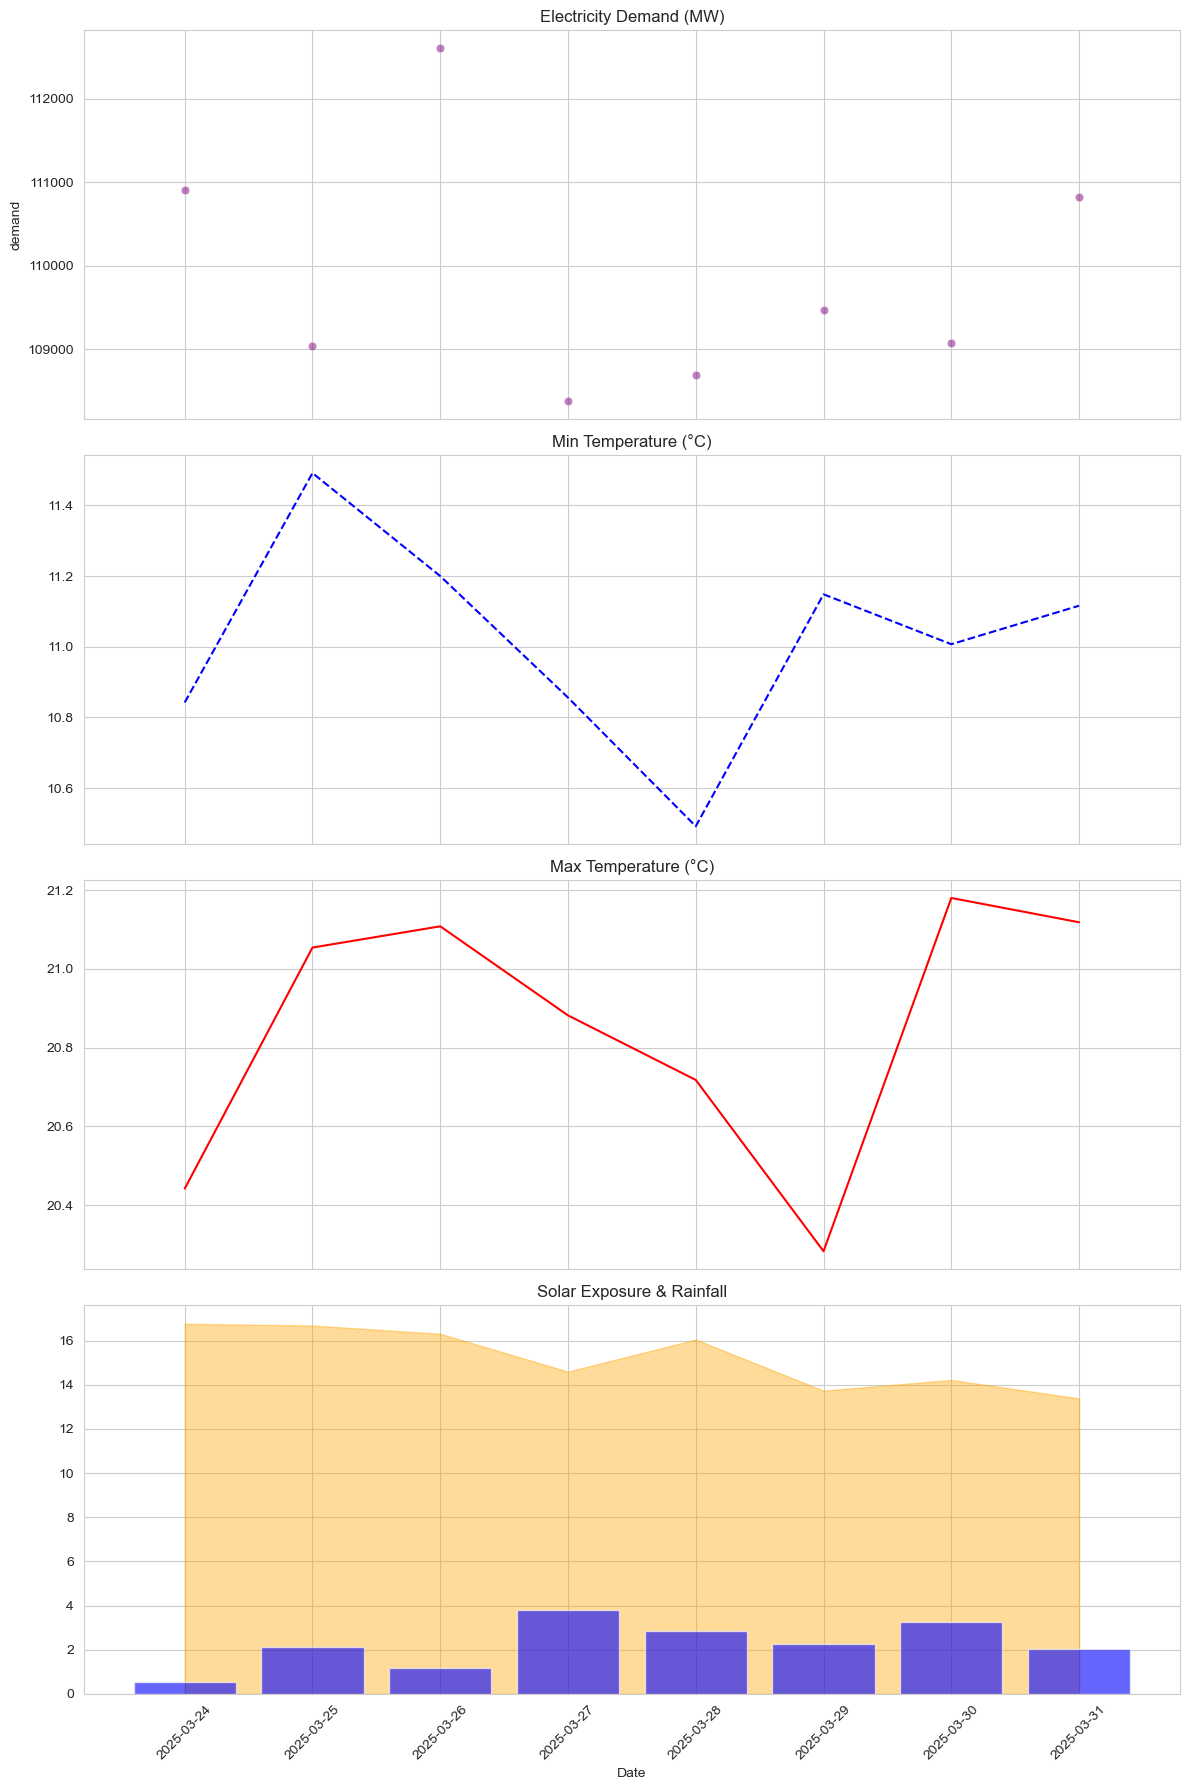

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Option 1: Raw string
file_path = r"C:\Users\chint\Downloads\preprocess dataset.csv"

# OR Option 2: Escaped backslashes
# file_path = "C:\\Users\\chint\\Downloads\\preprocess dataset.csv"

df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])

# Define target variables for multivariate forecasting
targets = ['min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'demand']

# Add seasonal & lag features
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

# Add 30-day rolling averages for trend learning
for target in targets:
    df[f'{target}_lag30'] = df[target].rolling(window=30).mean()

df.dropna(inplace=True)  # Remove NaN values caused by rolling average

# Features and target selection
features = ['min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'month', 'day_of_year'] + \
           [f"{target}_lag30" for target in targets]
X = df[features]
y = df[targets]

# Normalize data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Create sequences (lookback = 10 days)
lookback = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - lookback):
    X_seq.append(X_scaled[i : i + lookback])
    y_seq.append(y_scaled[i + lookback])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split into training & testing sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, len(features))),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(len(targets))
])

# Compile and train model
model.compile(optimizer='adam', loss=MeanSquaredError())
model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Save model & scalers
model.save("lstm_forecasting_model.h5")  # Save LSTM model
joblib.dump(scaler_X, "scaler_X.joblib")  # Save input scaler
joblib.dump(scaler_y, "scaler_y.joblib")  # Save output scaler
print("Model and scalers saved successfully!")

# Load model & scalers (for future use)
loaded_model = load_model("lstm_forecasting_model.h5", custom_objects={"mse": MeanSquaredError()})
scaler_X = joblib.load("scaler_X.joblib")
scaler_y = joblib.load("scaler_y.joblib")
print("Model and scalers loaded successfully!")

# Predict on test set
y_pred = loaded_model.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f' RMSE: {rmse}\n MAE: {mae}\n MSE: {mse}')

# Future Forecasting (Faster Execution)
def predict_future():
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    future_dates = pd.date_range(start=start_date, end=end_date)
    num_days = len(future_dates)

    input_seq = X_scaled[-lookback:].reshape(1, lookback, len(features))
    predictions = np.zeros((num_days, len(targets)))

    for i in range(num_days):
        pred = loaded_model.predict(input_seq, verbose=0)[0]
        pred = np.maximum(pred + np.random.normal(0, 0.02, size=pred.shape), 0)  # Add slight noise
        predictions[i] = pred

        new_date = future_dates[i]
        month, day_of_year = new_date.month, new_date.dayofyear
        seasonal_features = [
            np.sin(2 * np.pi * month / 12),
            np.cos(2 * np.pi * month / 12),
            np.sin(2 * np.pi * day_of_year / 365),
            np.cos(2 * np.pi * day_of_year / 365)
        ]

        new_row = np.hstack([pred[:4], seasonal_features])
        new_row = np.pad(new_row, (0, input_seq.shape[2] - len(new_row)))  # Ensure same shape
        input_seq = np.roll(input_seq, -1, axis=1)
        input_seq[0, -1, :] = new_row

    predictions = scaler_y.inverse_transform(predictions)
    result = pd.DataFrame(predictions, index=future_dates, columns=targets)
    print("\n🔹 Future Weather & Demand Forecast 🔹")
    print(result)
    return result

# Plot Forecast
def plot_forecast(df):
    sns.set_style("whitegrid")
    df.index = pd.to_datetime(df.index, errors='coerce')
    fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

    sns.scatterplot(ax=axes[0], x=df.index, y=df["demand"], color='purple', alpha=0.5)
    axes[0].set_title("Electricity Demand (MW)")

    axes[1].plot(df.index, df["min_temperature"], linestyle="dashed", color='blue')
    axes[1].set_title("Min Temperature (°C)")

    axes[2].plot(df.index, df["max_temperature"], linestyle="solid", color='red')
    axes[2].set_title("Max Temperature (°C)")

    axes[3].fill_between(df.index, df["solar_exposure"], color='orange', alpha=0.4)
    axes[3].bar(df.index, df["rainfall"], color='blue', alpha=0.6)
    axes[3].set_title("Solar Exposure & Rainfall")

    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run Future Prediction & Plot
result = predict_future()
if result is not None:
    plot_forecast(result)
